<a href="https://colab.research.google.com/github/abhayk-c/Cat-Dog-Classifier-Model/blob/main/Cat_Dog_Classifier_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Environment Setup

In [2]:
# Environment setup
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

# Step 2: Create our Data Set

We create our data set by scraping the web for cat and dog images. We use the duckduckgo search engine because it's API is relatively easy to work with.

In [ ]:
# Now let's define a function that can download categories of images for us.
# We download images using duckduckgo's image search engine.
def download_image_categories(path: Path, categories: List[str], max_images_per_category):
  if not path.exists():
    path.mkdir()
    for img_category in categories:
      dest = (path/img_category)
      dest.mkdir(exist_ok=True)
      results = search_images_ddg(img_category, max_images_per_category)
      download_images(dest, urls=results)

In [ ]:
# Using our helper function let's download images of cats and dogs from the web
# and save them in our file system in a training_data/ folder.
training_data_folder = Path('training_data')
download_image_categories(training_data_folder, ['pet cat', 'wild cat', 'pet dog', 'wild dog'], 100)

# Delete any invalid image files that get downloaded.
image_paths = get_image_files(training_data_folder)
failed = verify_images(image_paths)
failed.map(Path.unlink)

(#14) [None,None,None,None,None,None,None,None,None,None,None,None,None,None]

In [ ]:
# It's useful to save a backup of the downloaded data set for debugging
# and reuse purposes so saving a backup here so it can be downloaded if needed.
!ls
!zip -r training_data.zip training_data/

#!unzip training_data.zip

Archive:  training_data.zip
   creating: training_data/
  inflating: __MACOSX/._training_data  
  inflating: training_data/.DS_Store  
  inflating: __MACOSX/training_data/._.DS_Store  
   creating: training_data/wild cat/
  inflating: __MACOSX/training_data/._wild cat  
   creating: training_data/wild dog/
  inflating: __MACOSX/training_data/._wild dog  
   creating: training_data/pet dog/
  inflating: __MACOSX/training_data/._pet dog  
   creating: training_data/pet cat/
  inflating: __MACOSX/training_data/._pet cat  
  inflating: training_data/wild cat/ede401d5-33c7-4438-9749-4eb47e3394d8.jpg  
  inflating: __MACOSX/training_data/wild cat/._ede401d5-33c7-4438-9749-4eb47e3394d8.jpg  
  inflating: training_data/wild cat/1dcb0316-faec-480b-9e9c-c298440fd796.jpg  
  inflating: __MACOSX/training_data/wild cat/._1dcb0316-faec-480b-9e9c-c298440fd796.jpg  
  inflating: training_data/wild cat/cc6044af-0e72-4a2b-b65e-16880c4feb07.jpg  
  inflating: __MACOSX/training_data/wild cat/._cc6044af-0e

# Step 3: Let's train our ML Model

Now we train our ML Model to classify cats and dogs. We leverage the transfer learning technique to fine tune the popular resnet18 image model to specifically classify cats and dogs. We use fastAI framework and vision learner for quicker prototyping and training because it provides a lot of conveniences we can reuse.

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.082505,0.208699,0.129032,00:09


epoch,train_loss,valid_loss,error_rate,time
0,0.311160,0.078437,0.048387,00:09
1,0.217796,0.043618,0.016129,00:08
2,0.160427,0.056875,0.016129,00:09
3,0.122639,0.062194,0.016129,00:09


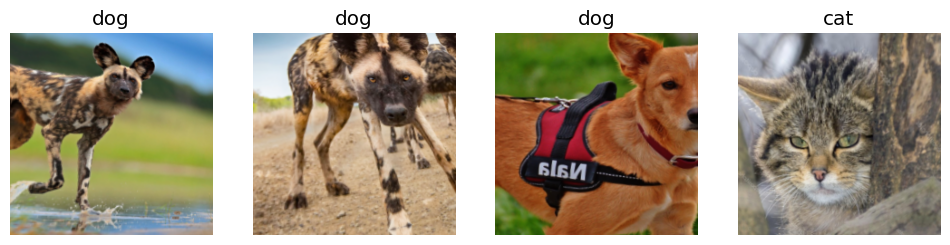

In [ ]:
# We define a custom function that generates our training data's labels.
def get_classification_label(o):
  input_image_path = Path(o)
  path_components = input_image_path.parts
  parent_dir = path_components[len(path_components) - 2]
  tokens = parent_dir.split()
  if "dog" in tokens:
    return "dog"
  elif "cat" in tokens:
    return "cat"

# Define our data block that we will use to create our DataLoaders object.
# We resize our image to 224x224, which is the size dimenstion the resnet18 image
# model expects. Additionally we use a RandomResizedCrop transform to randomly
# crop to different sections of the image (a common data augmentation technique) used
# when training image models. Furthermore we will apply a standard set of data augmentation
# transforms to the images in "batch" during model training leveraging the convenient FastAI
# aug_transforms() function.
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_classification_label,
    item_tfms=[RandomResizedCrop(224, min_scale=0.5)],
    batch_tfms=aug_transforms())
data_loaders = data_block.dataloaders(Path('training_data'))
data_loaders.train.show_batch(max_n=4, nrows=1)

# Now we train our cat and dog image classifier model using fine tuning
# "transfer learning" approach
learn = vision_learner(data_loaders, resnet18, metrics=error_rate)
learn.fine_tune(4)

# Step 4: Clean data, export model, evaluate

We now evaluate our classifier's performance and export/save it for use in applications or further ML model tuning/training.

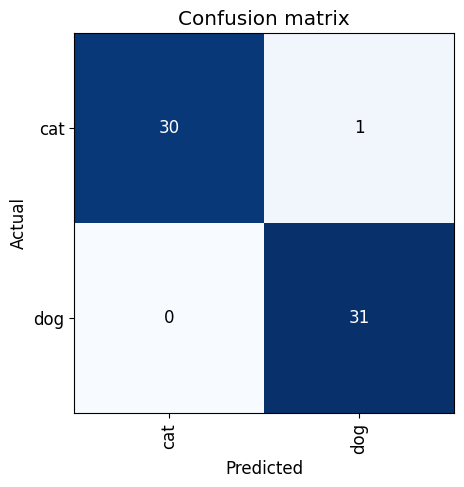

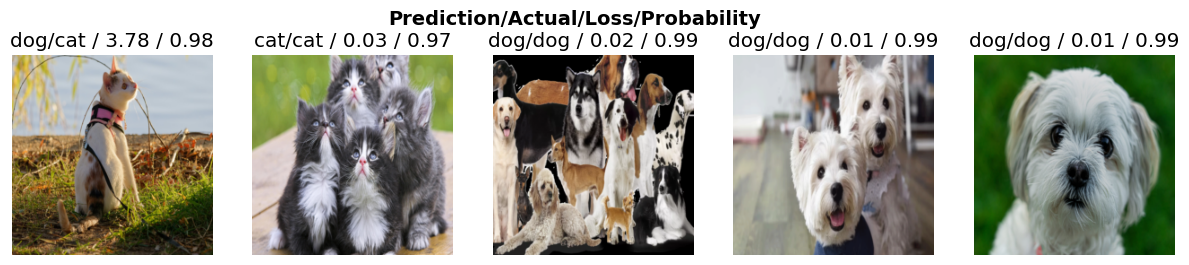

In [ ]:
# Let's plot the model confusion matrix and top losses to see how
# the model is performing.
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(5, nrows=1)

In [ ]:
# Let's use fastAI's data cleaner widget to see the top losses in our data set for
# each category and clean our data set if needed.
# This is a useful debugging/visualization but the data set was manually cleaned
# already before hand so everything looks good.
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
# Model has been trained and data set looks cleaned lets export our model
learn.export('cat_dog_classifier_model.pkl')

In [ ]:
# Let's now load the exported ML model and test the inferencing quality.
# I manually created my own test set with dogs, cats, and pictures of other animals/objects.
# Feel free to create your own test image folder and you can reuse the cell here to test
# model quality. This cell can be removed and replaced.

#!unzip test_data.zip

model_inference = load_learner('cat_dog_classifier_model.pkl')
print(model_inference.dls.vocab)

# 63% accuracy
print(model_inference.predict('test_data/dogs/Dog1.jpg'))
print(model_inference.predict('test_data/dogs/Dog2.jpeg'))
print(model_inference.predict('test_data/dogs/Dog3.jpeg'))
print(model_inference.predict('test_data/dogs/Dog4.jpg'))
print(model_inference.predict('test_data/dogs/Dog5.jpg'))
print(model_inference.predict('test_data/dogs/Dog6.jpg'))
print(model_inference.predict('test_data/dogs/Dog7.jpg'))

# 100% accuracy
print(model_inference.predict('test_data/cats/Cat1.jpg'))
print(model_inference.predict('test_data/cats/Cat2.jpg'))
print(model_inference.predict('test_data/cats/Cat3.jpeg'))
print(model_inference.predict('test_data/cats/Cat4.jpeg'))
print(model_inference.predict('test_data/cats/Cat5.jpg'))


['cat', 'dog']


('cat', tensor(0), tensor([0.7691, 0.2309]))


('cat', tensor(0), tensor([0.9176, 0.0824]))


('dog', tensor(1), tensor([0.0015, 0.9985]))


('cat', tensor(0), tensor([0.6644, 0.3356]))


('dog', tensor(1), tensor([0.0106, 0.9894]))


('dog', tensor(1), tensor([0.4033, 0.5967]))


('dog', tensor(1), tensor([3.8866e-06, 1.0000e+00]))


('cat', tensor(0), tensor([0.9641, 0.0359]))


('cat', tensor(0), tensor([1.0000e+00, 1.8591e-08]))


('cat', tensor(0), tensor([0.9971, 0.0029]))


('cat', tensor(0), tensor([0.8746, 0.1254]))


('cat', tensor(0), tensor([1.0000e+00, 6.0291e-08]))


('dog', tensor(1), tensor([0.1501, 0.8499]))


('cat', tensor(0), tensor([0.9783, 0.0217]))


('cat', tensor(0), tensor([0.7017, 0.2983]))


('dog', tensor(1), tensor([0.0300, 0.9700]))


('dog', tensor(1), tensor([0.1524, 0.8476]))


# Model Results and Conclusion

**Observations**

1. The model has a 75% accuracy rate on the test data.
2. The model is better at classifying cats vs dogs (100% vs 63%)
3. The reason for the inconsistency is in the training data. The downloaded training data set for cats represents a wider distribution of cat breeds, species, and sizes. The downloaded training data for dogs heavily skews towards certain popular domestic dog breeds, small size dogs, and puppies.

**Improving Model Quality**
- In order to improve the model quality I would introduce more distribution of dog breeds (both wild/stray and domestic) in the training set which should improve the prediction accuracy of the dog label.
- I would also introduce real world images into both training sets (captured on iphones, shared in social media/applications). I noticed the model performed well on web images and prediction quality degraded a bit on images captured on friends iPhones.

**A note on the Classifier**
- The model will ONLY work on images of cats and dogs. If an image other than a cat or dog is provided the behavior is undefined, it will likely predict a cat or dog label with high confidence.
- This is because this model was only trained on labeled cat and dog data, to accurately predict the inverse case (not a dog or cat), a newly labeled data set with a label of "unknown" that contains a wide distribution of non-cat/non-dog objects is needed. Due to time needed in creating such data set I did not introduce this into the training data but it could easily be done.

